In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential, load_model
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score,adjusted_rand_score,v_measure_score, completeness_score, homogeneity_score, silhouette_score,roc_curve, auc, f1_score, precision_recall_curve, precision_score,recall_score,accuracy_score,confusion_matrix
sys.path.append('/Users/chenpete/Documents/ESP/practicum/autoencoders/code/')
from sklearn.neighbors import BallTree
from utils import * 
from sklearn.linear_model import LogisticRegression


# Configuration

In [4]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/'

In [5]:
df = pd.read_csv(DATA_DIR + 'creditcard_default.csv')

In [6]:
df.shape

(30000, 25)

In [7]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [8]:
non_scale_cols = ['y','y_rank']
param_cols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

y_col = 'y'
early_step = 0

df['y'] = df['default payment next month']
X_train, X_test, y_train, y_test, y_rank_train, y_rank_test = preprocess_data(df,param_cols,y_col, non_scale_cols,early_step,test_size=.3,timeseries=False)

In [9]:
y_train.value_counts()

0    16354
Name: y, dtype: int64

In [10]:
y_test.value_counts()

0    7010
1    6636
Name: y, dtype: int64

In [11]:
y_rank_test.value_counts()

0    7010
1    6636
Name: y_rank, dtype: int64

In [12]:
X_train.shape

(16354, 23)

# Model 1: Layer autoencoder

In [43]:
model = simple_ann_autoencoder_regression(param_cols,16,8,16)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                384       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_8 (Dense)              (None, 23)                391       
Total params: 1,055
Trainable params: 1,055
Non-trainable params: 0
_________________________________________________________________


In [44]:
history_callback = model.fit(X_train,X_train,epochs=50,batch_size = 32)
loss_history = history_callback.history['loss']

Epoch 1/50
16354/16354 [==============================] - 1s 37us/step - loss: 0.6397
Epoch 2/50
16354/16354 [==============================] - 0s 24us/step - loss: 0.3825
Epoch 3/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.3035
Epoch 4/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.2678
Epoch 5/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.2434
Epoch 6/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.2283
Epoch 7/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.2194
Epoch 8/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.2088
Epoch 9/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.2024
Epoch 10/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.1953
Epoch 11/50
16354/16354 [==============================] - 0s 25us/step - loss: 0.1918
Epoch 12/50
16354/16354 [===========================

In [45]:

#model=load_model('autoencoder_default.h5')
model.save('autoencoder_default.h5')

Text(0.5, 1.0, 'loss history')

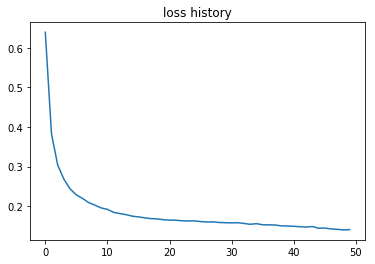

In [46]:
plt.plot(loss_history)
plt.title('loss history')

In [47]:
X_pred_test = model.predict(X_test)
X_pred_train = model.predict(X_train)

df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test)
df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train)

In [48]:
res_nominal_train = df_results_train[df_results_train['y'] == 0]['residual_avg']

average_res_nominal_train = np.mean(res_nominal_train)
std_res_nominal_train = np.std(res_nominal_train)

threshold_3s = average_res_nominal_train + 3*std_res_nominal_train
threshold_5s = average_res_nominal_train + 5*std_res_nominal_train
threshold_max = np.max(res_nominal_train)

threshold_list = [('3s',threshold_3s),('5s',threshold_5s),('max',threshold_max)]

### Training residuals

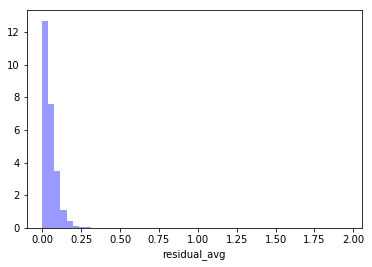

In [49]:
plt.figure()
sns.distplot(df_results_train['residual_avg'],norm_hist=True,kde=False,color='blue')

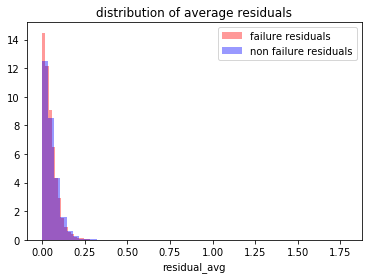

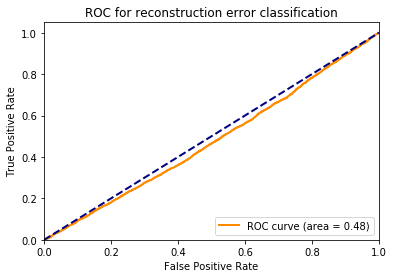



------ Using threshold 3s---------------
accuracy = 0.511
precision = 0.385
recall = 0.009
f1 = 0.018


------ Using threshold 5s---------------
accuracy = 0.512
precision = 0.167
recall = 0.001
f1 = 0.002


------ Using threshold max---------------
accuracy = 0.514
precision = 0.000
recall = 0.000
f1 = 0.000


/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
res_nominal_test = df_results_test[df_results_test['y'] == 0]['residual_avg']
res_failures_test = df_results_test[df_results_test['y'] == 1]['residual_avg']

plt.figure()
sns.distplot(res_failures_test,norm_hist=True,kde=False,color='red')
sns.distplot(res_nominal_test,norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of average residuals')

y_true = np.array(df_results_test['y'])
y_pred_proba = np.array(df_results_test['residual_avg']/np.max(df_results_test['residual_avg']))

plot_roc(y_true,y_pred_proba)

for name,threshold in threshold_list:
    print('\n\n------ Using threshold {}---------------'.format(name))
    y_pred_threshold = np.where(df_results_test['residual_avg'] > threshold, 1, 0)

    print('accuracy = {:.3f}'.format(accuracy_score(y_true,y_pred_threshold)))
    print('precision = {:.3f}'.format(precision_score(y_true,y_pred_threshold)))
    print('recall = {:.3f}'.format(recall_score(y_true,y_pred_threshold)))
    print('f1 = {:.3f}'.format(f1_score(y_true,y_pred_threshold)))


(0, 0.75)

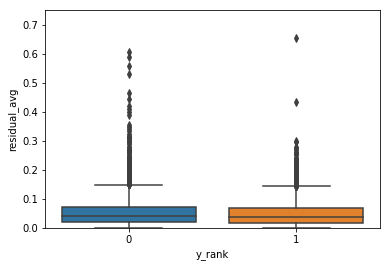

In [51]:
sns.boxplot(x='y_rank',y='residual_avg',data=df_results_test)
plt.ylim((0,.75))

# Apply KNN nearest distance approach for reconstruction error

In [52]:
residuals_test = X_pred_test - X_test
residuals_train = X_pred_train - X_train

In [53]:
nominal_idx = y_test ==0
failure_idx = y_test ==1

In [54]:
residuals_test.shape

(13646, 23)

In [55]:
tree = BallTree(residuals_train)

In [56]:
dist,ind = tree.query(residuals_test,k=2)
dist =np.mean(dist,axis=1)
dist = pd.Series(dist.ravel(),index=residuals_test.index)

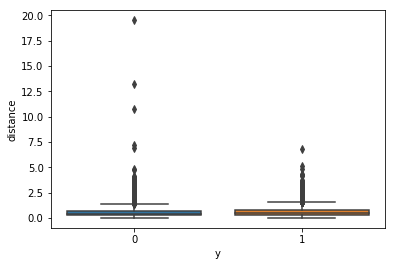

In [57]:
df_boxplot = pd.DataFrame(data = {'distance':dist,'y' : y_test})
sns.boxplot(x='y',y='distance',data=df_boxplot)

Text(0.5, 1.0, 'distribution of std residual')

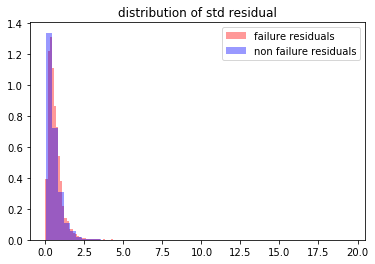

In [58]:
plt.figure()
sns.distplot(dist[failure_idx],norm_hist=True,kde=False,color='red')
sns.distplot(dist[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of std residual')

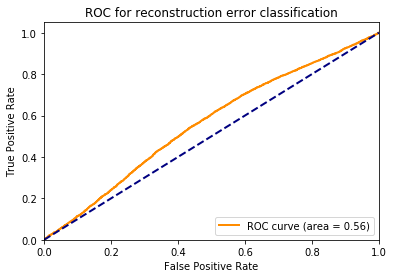

In [59]:
y_pred_proba_knn = dist/np.max(dist)
plot_roc(y_test,y_pred_proba_knn)

In [60]:
y_pred_threshold_knn = np.where(dist > 1.1, 1, 0)
print('accuracy = {:.3f}'.format(accuracy_score(y_test,y_pred_threshold_knn)))
print('precision = {:.3f}'.format(precision_score(y_test,y_pred_threshold_knn)))
print('recall = {:.3f}'.format(recall_score(y_test,y_pred_threshold_knn)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_test,y_pred_threshold_knn)))
print(confusion_matrix(y_test,y_pred_threshold_knn))

accuracy = 0.517
precision = 0.517
recall = 0.107
f1 = 0.178


[[6346  664]
 [5925  711]]


# Try Logistic Regression on reconstruction error

In [61]:
X_residual_train, X_residual_test, y_residual_train, y_residual_test = train_test_split(residuals_test, y_test, test_size=0.5, random_state=0, stratify = y_test)

In [62]:
y_residual_train.value_counts()

0    3505
1    3318
Name: y, dtype: int64

In [63]:
y_residual_test.value_counts()

0    3505
1    3318
Name: y, dtype: int64

In [64]:
clf = LogisticRegression(C=10)
clf.fit(X_residual_train,y_residual_train)
y_pred_logreg_proba = clf.predict_proba(X_residual_test)[:,1]

/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


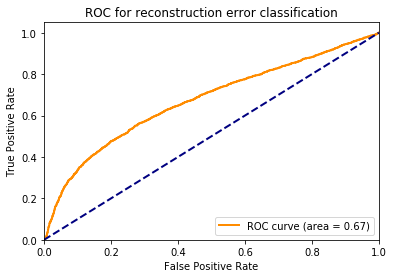

In [65]:
plot_roc(y_residual_test,y_pred_logreg_proba)

Text(0.5, 1.0, 'distribution of logistic regression probability')

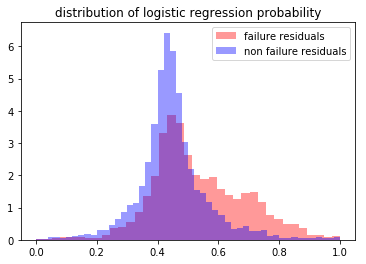

In [66]:
plt.figure()
sns.distplot(y_pred_logreg_proba[y_residual_test==1],norm_hist=True,kde=False,color='red')
sns.distplot(y_pred_logreg_proba[y_residual_test==0],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of logistic regression probability')

In [67]:
y_pred_threshold_logreg = np.where(y_pred_logreg_proba > .5, 1, 0)
print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_threshold_logreg)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_threshold_logreg)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_threshold_logreg)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_threshold_logreg)))
print(confusion_matrix(y_residual_test,y_pred_threshold_logreg))

accuracy = 0.640
precision = 0.674
recall = 0.501
f1 = 0.575


[[2702  803]
 [1655 1663]]


# Try decision tree on reconstruction error

In [40]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_residual_train,y_residual_train)
y_pred_dt = clf_dt.predict(X_residual_test)

print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_dt)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_dt)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_dt)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_dt)))
print(confusion_matrix(y_residual_test,y_pred_dt))

accuracy = 0.599
precision = 0.587
recall = 0.591
f1 = 0.589


[[2128 1377]
 [1357 1961]]


# Try Random Forest on reconstruction error

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
clf_rf.fit(X_residual_train,y_residual_train)
y_pred_rf = clf_rf.predict(X_residual_test)

print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_rf)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_rf)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_rf)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_rf)))
print(confusion_matrix(y_residual_test,y_pred_rf))

/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy = 0.657
precision = 0.680
recall = 0.558
f1 = 0.613


[[2634  871]
 [1468 1850]]
